# Lossless Compression

In [ ]:
!pip3 install dahuffman

In [119]:
import pandas as pd
from matplotlib import pyplot as plt
from dahuffman import HuffmanCodec
import re


import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 7]

TOKEN_PATTERN = r"[a-zA-Z ]+"
#TOKEN_PATTERN = r"(?u)\b[a-zA-Z]+\b|\</?s\>"

## Frequencies of English letters

In [120]:
with open("../data/pride and prejudice.txt", "rt") as f:
    text = f.read()

In [185]:
def ng_tokenize(text: str, ng: int) -> list:
    """
    extract ngram and add sepcial symbols
    
    Args:
      :text:  text
      :ng:    ngram level
      
    Returns:
      list of ngrams 
    """
    tokens = re.findall(TOKEN_PATTERN, text.lower())
    ngz = ngrams(tokens, ng,
                 pad_left=True, pad_right=True,
                 left_pad_symbol=SENT_START_TOKEN,
                 right_pad_symbol=SENT_END_TOKEN)
    return list(ngz)


def clean_text(text, pattern=TOKEN_PATTERN):
    """
    Remove non letters and lowercase text
    """
    tokens = re.findall(TOKEN_PATTERN, text.lower()) # tokenize
    return re.sub(" +", " ", " ".join(tokens))  # merge consecutive spaces to one

#### based on natural English letter frequencies

load natural English letter frequencies

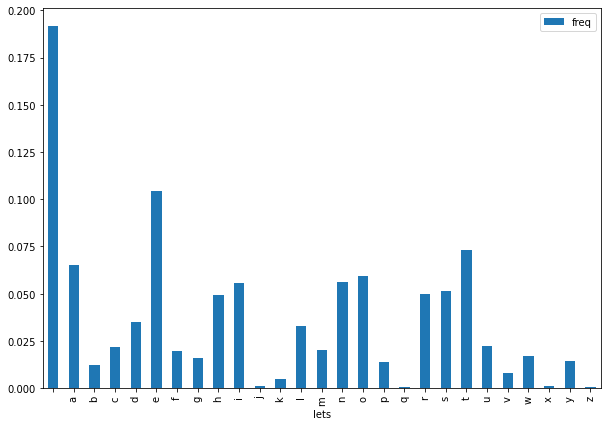

In [122]:
dff = pd.read_csv("../data/English_letter_frequency.csv", encoding='utf-8')

dff.plot.bar(x='lets', y='freq')
plt.show()

In [123]:
def expected_code_length(codec, probs):
    tbl = codec.get_code_table()
    L = 0
    for k in probs:
        L += probs[k]*tbl[k][0]
    return L

In [186]:
probs = dict(zip(dff['lets'],dff['freq']))
codec = HuffmanCodec.from_frequencies(probs)  # construct code
codec.print_code_table()

Bits Code        Value Symbol
   1 0               0 _EOF
   6 100000         32 'c'
   6 100001         33 'u'
   5 10001          17 'h'
   5 10010          18 'r'
   5 10011          19 's'
   4 1010           10 'e'
   5 10110          22 'i'
   5 10111          23 'n'
   7 1100000        96 'b'
   7 1100001        97 'p'
   7 1100010        98 'y'
   7 1100011        99 'g'
   5 11001          25 'o'
   5 11010          26 'a'
   6 110110         54 'l'
   7 1101110       110 'w'
   8 11011110      222 'v'
  11 11011111000  1784 'z'
  11 11011111001  1785 'q'
  11 11011111010  1786 'j'
  11 11011111011  1787 'x'
   9 110111111     447 'k'
   5 11100          28 't'
   6 111010         58 'd'
   7 1110110       118 'f'
   7 1110111       119 'm'
   4 1111           15 ' '


In [140]:
text_to_encode = clean_text(text) # clean text
encoded = codec.encode(text_to_encode)  # encode
decoded = codec.decode(encoded)

assert decoded == text_to_encode

print(f"Length original: {decoded.__sizeof__()} bytes")
print(f"Length encoded: {encoded.__sizeof__()} bytes")
print(f"Redundancy: {1 - encoded.__sizeof__()/decoded.__sizeof__()}")
print("==============================================")
print(f"Expected bits per letter: {expected_code_length(codec,probs)} bits")
print(f"Actual bits per letter encoded: {8 * encoded.__sizeof__()/len(text_to_encode)} bits")
print(f"Entropy of English letter frequency distrubition: {-np.sum(np.log2(dff['freq']) * dff['freq'])} bits")

Length original: 677050 bytes
Length encoded: 434619 bytes
Redundancy: 0.3580695665017355
Expected bits per letter: 5.1125529 bits
Actual bits per letter encoded: 5.135815161277457 bits
Entropy of English letter frequency distrubition: 4.072253276219117 bits


In [141]:
print("How does the encoded message look like in binary:")
message = "it was the best of times"
encoded = codec.encode(message)
print("Message: ", message)
print("Binary:")
print("|".join([f'{c:b}' for c in encoded]))
print("Hexa:")
print("|".join([f'{c:x}' for c in encoded]))

How does the encoded message look like in binary:
Message:  it was the best of times
Binary:
10110111|111111|1110110|10100111|11111100|10001101|1111110|1010|10011111|111111|111101|10111111|10010110|11101111|1010011
Hexa:
b7|3f|76|a7|fc|8d|7e|a|9f|3f|3d|bf|96|ef|53


#### based on letter frequencies in the text 

In [159]:
text_to_encode = clean_text(text).encode('utf-8')  # clean text

codec = HuffmanCodec.from_data(text_to_encode)  # construct code
encoded = codec.encode(text_to_encode)  # encode
decoded = codec.decode(encoded)


print(f"Length original: {decoded.__sizeof__()} bytes")
print(f"Length encoded: {encoded.__sizeof__()} bytes")
print(f"Redundancy: {1 - encoded.__sizeof__()/decoded.__sizeof__()}")
print(f"Actual bits per letter: {8*encoded.__sizeof__()/len(text_to_encode)}")
print("==============================================")


Length original: 677034 bytes
Length encoded: 349942 bytes
Redundancy: 0.4831249243021768
Bits per letter: 4.135202163660024


#### Encode text without cleaning 

In [158]:
text_to_encode = text.encode('utf-8')  # original text

codec = HuffmanCodec.from_data(text_to_encode)  # construct code
encoded = codec.encode(text_to_encode)  # encode
decoded = codec.decode(encoded)


print(f"Length original: {decoded.__sizeof__()} bytes")
print(f"Length encoded: {encoded.__sizeof__()} bytes")
print(f"Redundancy: {1 - encoded.__sizeof__()/decoded.__sizeof__()}")
print(f"Actual bits per letter: {8*encoded.__sizeof__()/len(text_to_encode)}")
print("==============================================")

Length original: 782423 bytes
Length encoded: 427558 bytes
Redundancy: 0.45354622755210416
Bits per letter: 4.371814568182109


## Encoding Letter Pairs:

In [187]:
probs2 = {}
for k1 in probs:
    for k2 in probs:
        probs2[k1 + k2] = probs[k1] * probs[k2]

freqs = np.array(list(probs2.values()))
print(f"Entropy of English 2letter frequency distrubition: {-np.sum(np.log2(freqs) * freqs)/2} [bits per letter]")
        
codec = HuffmanCodec.from_frequencies(probs2)  # construct code

tbl = codec.get_code_table()

df = pd.DataFrame(tbl).T[1:].rename(columns={0 : 'Bits',  1: 'Value'})
df['Code'] = ['{0:b}'.format(c) for c in df['Value']]
dfd = df[['Bits', 'Value', 'Code']].sort_values(['Bits'])
print(dfd[20:])
#df

print(f"Expected code length per letter: {expected_code_length(codec, probs2)/2}")

pairs = [chr(t[0])+chr(t[1]) for t in zip(text_to_encode[0::2], text_to_encode[1::2])]
encoded = codec.encode(pairs)  # encode
decoded = codec.decode(encoded)

print("==============================================")
print(f"Length original: {decoded.__sizeof__()} bytes")
print(f"Length encoded: {encoded.__sizeof__()} bytes")
print(f"Redundancy: {1 - encoded.__sizeof__()/decoded.__sizeof__()}")
print(f"Actual bits per letter: {8*encoded.__sizeof__()/len(text_to_encode)}")



Entropy of English 2letter frequency distrubition: 4.072253276219117 [bits per letter]
    Bits    Value                    Code
oe     8      152                10011000
h      8      226                11100010
 r     8      228                11100100
r      8      229                11100101
ei     8      138                10001010
..   ...      ...                     ...
jz    21  1256177   100110010101011110001
xj    21  1903062   111010000100111010110
qq    21  1256179   100110010101011110011
zz    22  3806126  1110100001001110101110
qz    22  3806127  1110100001001110101111

[709 rows x 3 columns]
Expected code length per letter: 4.5881874318587075
Length original: 677049 bytes
Length encoded: 390444 bytes
Redundancy: 0.42331500378849984
Actual bits per letter: 4.6138070697089075


# Markov chains

In [188]:
from scipy.stats import multinomial

In [189]:

def sample_Markov_path(Q, initial_probs, n):
    """
    Sample from a path from a Markov chain
    
    Args:
        :Q:  transition probability matrix
        :initial_probs:  vector of probabilities of the initial state
        :n:  length of path
    
    Return:
        :xx:  sample from the Markov chain of length n
        
    """

    M = Q.shape[0]
    xx = np.zeros((n,M))

    prob_vec = initial_probs

    for i in range(n):
        xx[i] = multinomial.rvs(p=prob_vec, n=1)
        prob_vec = xx[i] @ Q

    return np.argmax(xx, 1)

First 100 symbols:
[0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]


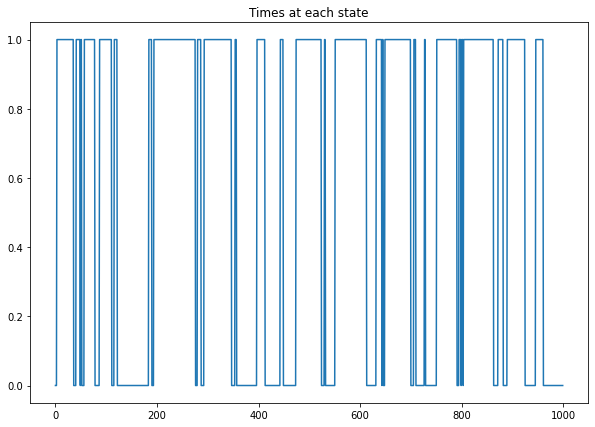

In [190]:
alpha = 0.1
beta = 0.05

Q = np.array([
    [1-alpha, alpha],
    [beta, 1-beta]
])

n = 1000
initial_probs = [1, 0]  # start at state 0
xx = sample_Markov_path(Q, initial_probs, n)


print("First 100 symbols:")
print(xx[:100])
plt.plot(xx)
plt.title(f"Times at each state")
plt.show()


In [191]:
v = np.linalg.eig(Q.T)[1].T[1]
nv = v / np.sum(v)
nv

array([0.33333333, 0.66666667])

In [192]:
nv @ Q - nv

array([0., 0.])

In [193]:
def h2(p):
    return -p * np.log2(p) - (1-p) * np.log2(1-p)

mu = np.array([beta/(alpha+beta), alpha/(alpha+beta), ])

print("Empirical distribution of P(x=1): ", xx.mean(0))
print("Statioanry distribution of P(x=1): ", mu[1])
print("Entropy Rate: ", mu @ np.array([h2(alpha), h2(beta)]) )

Empirical distribution of P(x=1):  0.618
Statioanry distribution of P(x=1):  0.6666666666666666
Entropy Rate:  0.34726316927373124


## Compressing Markov Chains

In [656]:
def entropy(p):
    return -np.sum(p * np.log2(p))

In [194]:
monograms = pd.read_csv("~/Downloads/1-grams.tsv", sep = '\t')
bigrams = pd.read_csv("~/Downloads/2-grams.tsv", sep = '\t')

monograms['tot'] = monograms.sum(1)
bigrams['tot'] = bigrams.sum(1)
monograms['freq'] = monograms['tot'] / monograms['tot'].sum()
bigrams['freq'] = bigrams['tot'] / bigrams['tot'].sum()

In [195]:
mono_dict = dict(zip(monograms['1-gram'], monograms['freq']))
bigrams_dict = dict(zip(bigrams['2-gram'], bigrams['freq']))

In [196]:
bigrams = bigrams.drop(index = 89)

In [199]:
# convert to a dataframe

def let2idx(let):
    return ord(let) - 65

letters = [l for l in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ']
P_XY = pd.DataFrame(columns=letters)
P_YgX = pd.DataFrame(columns=letters)


for K in bigrams['2-gram']:
    P_XY.loc[K[0], K[1]] = bigrams_dict[K]
    P_YgX.loc[K[0], K[1]] = bigrams_dict[K] / mono_dict[K[0]]
P_XY = P_XY.sort_index().fillna(0)  
P_YgX = P_YgX.sort_index().fillna(0)  

In [200]:
# transition matrix:
Q = (P_YgX.T / P_YgX.sum(1)).T

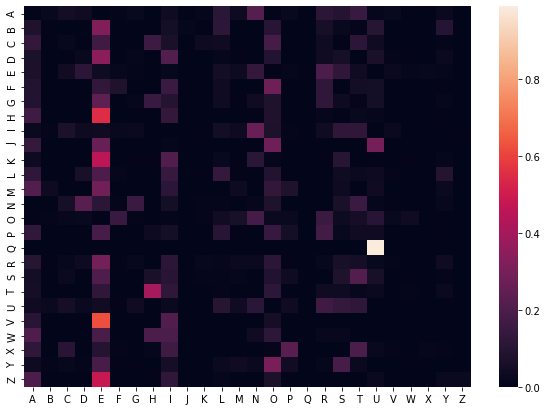

In [201]:
import seaborn as sns
sns.heatmap(Q)
plt.savefig('/Users/kipnisal/Downloads/Q_bigrams.png')
plt.show()

### Entropy rate:

In [203]:
# stationary distribution
lmd, V = np.linalg.eig(Q.T) # left eigenvector
mu = np.real(V.T[0]) # first left eigenvector
mu = mu / np.sum(mu) # normalize

assert np.linalg.norm(mu @ Q - mu) < 1e-10

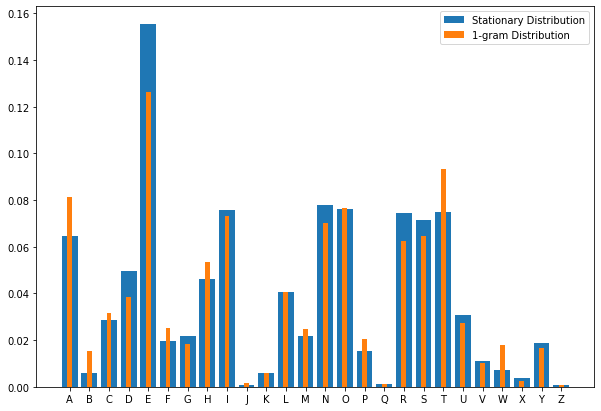

In [204]:
plt.bar(letters,mu)
plt.bar(mono_dict.keys(), mono_dict.values(), width=.25)
plt.legend(['Stationary Distribution', '1-gram Distribution'])
plt.savefig('/Users/kipnisal/Downloads/stat_dist_bigrams.png')
plt.show()

We compute the entropy rate using the formula:
$$
\bar{H}(\Xcal) = -\sum_{s,t}\mu(s) Q(s|t) \log_2(Q(s|t))
$$

In [205]:
print("Entropy rate of the chain: ", np.sum(mu @ -(np.log2(Q+1e-20) * Q)))

Entropy rate of the chain:  3.3081077290852963


Interpertation: no code can compress random samples from the Markov chain defined by the bigram model with an average length of less than $\approx 3.31$ bits per symbol. 

We can compare the last number to the entropy of the bigram distribution:

In [206]:
print("Entropy of the bigram distribution: ", entropy(bigrams.freq) / 2)

Entropy of the bigram distribution:  3.6969541272292017


Can you explain the difference?

Samples from the Markov chain:

In [1061]:
from scipy.stats import multinomial
s = 'H'
n = 2000
sample = []
while n > 0:
    sample.append(s)
    s = letters[list(multinomial.rvs(p=Q.loc[s], n=1)).index(1)]
    n -= 1
    
"".join(sample)

'HORSEDEXINDDEPTUCENDINCHACHERSTHOSUIAGRATEDEFENONDIPLIGUNGHIRERDELIOTHELALARENUNEMPLAREYONTHYEMETRERALNDIVEDERVENDSONGETUINOFERATECOFAGHINMPPATHOWANDDSEXPREINGOPERREDOTESEDRLANEWOTHEDRESEABECRONTHEREESTHISPRISSECHEREGINITHENVEVEPLYOGINTHASHOFINGROLONDISTHERCEALSOTEROWIOPTSSHIOUNTHARACASOUNIGERONDAVESTHEISUREANTRONTIDSINERERMENLYIOMINCANTRKSERSUNCESEMISTABEREULIKECOUPLUSTONITSEEDINTCHEIFITHENGAROSYOWENDEMEATHEDIOREFTENONCADEREASHECINGREVESPSMERALARORHESONTENTALINCHANCTHTLESECOREDADGOATHESIRTEDGESSTWHAGLSINGEMNGEREREANCITODUCISUDETHOREVEMONGOSOREOURTHEANDAXTHEOFSIFOUMOMOFOSKEROFEREILDYPEYNDINGENDISOFOCTEDESSPHENGREDSEMANODERADASTHEANOUOPRITOUENGORDINLEPRURELLORENCCHEWEEQUCELOVEREENTHENDUENSEYONTHEATHESHEJESIOOFATTENESHORCILESIRITHENDSSERNITHURMATHECAMANDERELOUTHABERESESTHASTHETORNCTITHAESOMAINSSTORTHEFOFRARTHESIARDURTHNDOUDETHEROLATHATSEADSUAKSTISERSISITOWALOLDISTHEVEARAYODITILAIETIRBLERYONCLLWAMAKVIRMEREGRSUREFIMASESHENSINDEATONEORINTHEDSINGESESELOFINTALADUTHOFFFRCCTINOVESMUYSEREDEDROF

## Compressing letter N-gram and guessing

In [207]:
from ngram import *

In [208]:
with open("../data/The Adventures of Sherlock Holmes.txt", 'rt') as f:
    text = f.read()
print("Number of tokens = ", len(text.split()))

Number of tokens =  107337


In [209]:
text_simplified = simplify_text(text)

In [210]:
model_1g = build_ngram_model(text_simplified, 1)

Cleaning text...
Extracting tokens...
Counting tokens...
Computing frequencies...
Built a model with 8064 1-grams


In [212]:
model_1g.head(10)

,count,freq
0,,
</s>,7122,0.057908
<s>,7122,0.057908
the,5792,0.047094
and,3082,0.025059
i,3037,0.024693
to,2825,0.022970
of,2765,0.022482
a,2697,0.021929
in,1823,0.014822


In [213]:
avg_letters_per_word = np.sum(model_1g.reset_index()[0].apply(len) * model_1g.freq.values)
entropy_per_word = -np.sum(model_1g.freq * np.log2(model_1g.freq))
print("Entropy in bits per letter: ", entropy_per_word / avg_letters_per_word)

Entropy in bits per letter:  2.18706695203911


## Huffman coding

In [214]:
from dahuffman import HuffmanCodec

In [215]:
# construct Huffman code to words 
tokens_w_space = [k + ' ' for k in model_1g.reset_index()[0]] # (add a spcae at the end of each word)

probs = dict(zip(tokens_w_space,model_1g.freq))
codec = HuffmanCodec.from_frequencies(probs)  # construct code


In [217]:
# encode data

text_to_encode = text_simplified
tokens_to_encode = to_tokens(text_to_encode)
tokens_to_encode_spaces = [t+' ' for t in tokens_to_encode]
encoded = codec.encode(tokens_to_encode_spaces)

In [218]:
# decode and verify losslessness
assert codec.decode(encoded).strip() == text_to_encode # there is an extra space at the end because we added spaces

In [219]:
num_of_words = len(to_tokens(text_to_encode))
bits_per_word = 8 * (encoded.__sizeof__() / num_of_words)
print("Average code length in bits per letter: ", bits_per_word / avg_letters_per_word)

Average code length in bits per letter:  2.4435829060380754


## Guessing game with word bigrams

In [222]:
model_2g = build_ngram_model(text_simplified, 2)

Cleaning text...
Extracting tokens...
Counting tokens...
Computing frequencies...
Built a model with 50516 2-grams


In [223]:
from tqdm import tqdm

def token2guesses(token: list, state: list, model)->int:
    # number of trials the model need
    # to correctly guess the token
    
    p_next_token = model.loc[state]  # list 
    p_next_token.loc[:, 'rnk'] = range(1, len(p_next_token)+1) # rank tokens
    return p_next_token.loc[token]['rnk']  #  return the rank of the

def encode_by_guesses(tokens: list, model: pd.DataFrame)->list:
    """
    Transform list of 
    """

    list_of_guesses = []
    prev_s = tokens[0] # the first symbol is always '<s>'

    for s in tqdm(tokens[1:]):
        list_of_guesses.append(token2guesses(s, prev_s, model))
        prev_s = s
    return list_of_guesses

In [224]:
N = 10_000
tokens = to_tokens(text_simplified)[:N]
guesses = encode_by_guesses(tokens, model_2g)

  0%|          | 0/9999 [00:00<?, ?it/s]/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
100%|██████████| 9999/9999 [00:08<00:00, 1245.00it/s]


In [227]:
pd.DataFrame([tokens[:100], guesses[:100]]).T

,0,1
0,<s>,4.0
1,the,492.0
2,adventures,1.0
3,of,64.0
4,sherlock,1.0
...,...,...
95,reasoning,2.0
96,and,283.0
97,observing,3.0
98,machine,10.0


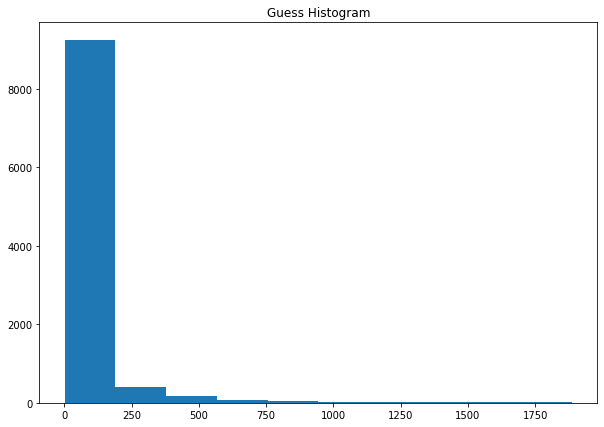

In [228]:
from matplotlib import pyplot as plt
plt.hist(guesses)
plt.title("Guess Histogram")
plt.show()

In [229]:
def entropy(probs):
    return -np.sum(probs[probs>0] * np.log2(probs[probs>0]))

df = pd.DataFrame(pd.DataFrame({'guess' : guesses}).value_counts('guess'), columns=['count'])
df['freq'] = df['count'] / df['count'].sum()

print("Entropy in bits per letter: ", entropy(df.freq) / avg_letters_per_word)

Entropy in bits per letter:  1.3649772757471963
